In [1]:
from typing import Literal

import numpy as np
import pandas as pd
import requests
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory

## Constants

In [2]:
DECISIVE_METRIC = 'hits_at_10'
DECISIVE_METRIC_OPTIMUM = 'max'

# Number of top k predictions to keep for generating
# new triple patterns
TOP_K = 10

# Set Seaborn theme
SEABORN_THEME = 'darkgrid'
sns.set_theme(style=SEABORN_THEME)

## Load Wikidata5M

In [3]:
SubsetType = Literal['train', 'valid', 'test']


def load_wikidata5m_dataset(subset_type: SubsetType):
    return pd.read_csv(f'dataset/wikidata5m/wikidata5m_transductive_{subset_type}.txt', sep='\t', names=['S', 'P', 'O'])


wikidata5m_train = load_wikidata5m_dataset('train')
wikidata5m_valid = load_wikidata5m_dataset('valid')
wikidata5m_test = load_wikidata5m_dataset('test')

## Load trained models and mappings

In [4]:
def get_trained_models():
    return {
        'complex': torch.load('embeddings/dim_32/complex/trained_model.pkl'),
        'distmult': torch.load('embeddings/dim_32/distmult/trained_model.pkl'),
        'simple': torch.load('embeddings/dim_32/simple/trained_model.pkl'),
        'transe': torch.load('embeddings/dim_32/transe/trained_model.pkl')
    }


def get_trained_entity_mappings():
    return {
        'complex': TriplesFactory.from_path_binary('embeddings/dim_32/complex/training_triples'),
        'distmult': TriplesFactory.from_path_binary('embeddings/dim_32/distmult/training_triples'),
        'simple': TriplesFactory.from_path_binary('embeddings/dim_32/simple/training_triples'),
        'transe': TriplesFactory.from_path_binary('embeddings/dim_32/transe/training_triples')
    }


trained_models = get_trained_models()
entity_mappings = get_trained_entity_mappings()

## Load predicate metrics

In [5]:
dim32_predicate_metrics = pd.read_csv('metrics/predicate_metrics.csv')

# Only consider realistic values, evaluated on both ends
dim32_predicate_metrics = dim32_predicate_metrics.query('Type == "realistic" and Side == "both"')

## Utilities

In [6]:
def get_wikidata_property_labels(property_ids: list) -> dict:
    wikidata_api = 'https://www.wikidata.org/w/api.php'
    params = {
        'action': 'wbgetentities',
        'ids': '|'.join(property_ids),
        'languages': 'en',
        'props': 'labels',
        'format': 'json'
    }

    response = requests.get(wikidata_api, params).json()

    property_labels = []
    for pid in property_ids:
        property_labels.append(response['entities'][pid]['labels']['en']['value'])

    return property_labels


def format_triple(subject, predicate, obj):
    if obj.startswith('?o'):
        return f'{subject} {predicate} {obj}   {get_wikidata_property_labels([subject, predicate])}'

    return f'{subject} {predicate} {obj}   {get_wikidata_property_labels([subject, predicate, obj])}'

## Functions

In [7]:
def find_train_triple_with_predicate(predicate_name):
    triples = wikidata5m_train.query('P == @predicate_name')

    if len(triples) > 0:
        i = np.random.randint(len(triples))
        random_triple = tuple(triples.iloc[i][['S', 'P', 'O']])
        return random_triple
    else:
        print(f'Error: No triples found for predicate {predicate_name} in training set')


def find_train_triple_with_subject(subject_name):
    triples = wikidata5m_train.query('S == @subject_name')

    if len(triples) > 0:
        i = np.random.randint(len(triples))
        random_triple = tuple(triples.iloc[i][['S', 'P', 'O']])
        return random_triple
    else:
        print(f'Error: No triples found for subject {subject_name} in training set')


def select_best_model(predicate_metrics, predicate_name):
    metrics_df = predicate_metrics.query('Metric == @DECISIVE_METRIC and relation_label == @predicate_name')

    optimal_metric = None
    if DECISIVE_METRIC_OPTIMUM == 'min':
        optimal_metric = metrics_df.loc[metrics_df['Value'].idxmin()]
    elif DECISIVE_METRIC_OPTIMUM == 'max':
        optimal_metric = metrics_df.loc[metrics_df['Value'].idxmax()]

    return optimal_metric['model']


def predict_tail(model_name, subject, predicate):
    model = trained_models[model_name]
    triples_factory = entity_mappings[model_name]

    return process_predictions(
        predict_target(
            model=model,
            head=subject,
            relation=predicate,
            tail=None,
            triples_factory=triples_factory
        ), model_name)


def process_predictions(predictions, model_name):
    predictions_df = predictions.df.assign(model=model_name)
    predictions_df = predictions_df.sort_values(by='score', ascending=False, ignore_index=True)
    return predictions_df.head(n=TOP_K)

## Best Model Counts

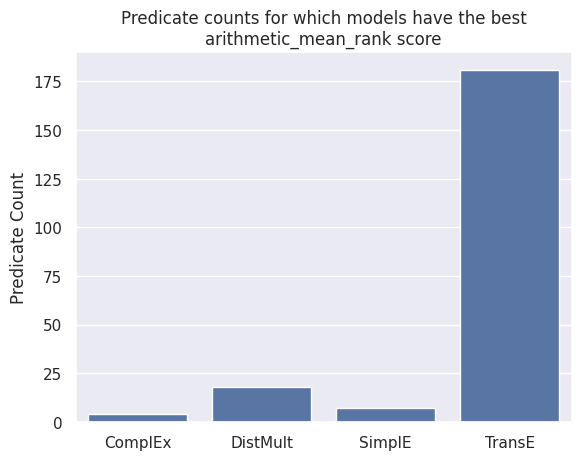

In [89]:
def compute_best_model_counts(predicate_metrics):
    predicate_metrics = predicate_metrics.query('Metric == @DECISIVE_METRIC')

    model_counts = {
        'complex': 0,
        'distmult': 0,
        'simple': 0,
        'transe': 0
    }
    for predicate_name, metrics_df in predicate_metrics.groupby(by='relation_label'):
        best_model = select_best_model(metrics_df, predicate_name)
        model_counts[best_model] += 1

    return pd.Series(model_counts)


def plot_best_model_counts(model_counts, embedding_dim=32):
    sns.set_theme(style=SEABORN_THEME)

    model_labels = ['ComplEx', 'DistMult', 'SimplE', 'TransE']
    if 'complex' not in model_counts.index.values:
        model_labels = ['DistMult', 'SimplE', 'TransE']

    # Plot best model counts
    ax = sns.barplot(data=model_counts)
    ax.set_title(f'Predicate counts for which dim{embedding_dim} models have the best\n{DECISIVE_METRIC} score')
    ax.set_ylabel('Predicate Count')
    ax.set_xticks(np.arange(len(model_labels)))
    ax.set_xticklabels(model_labels)

    plt.show()


best_model_counts = compute_best_model_counts(dim32_predicate_metrics)
plot_best_model_counts(best_model_counts)

# Predictions

## First Triple Prediction

In [65]:
start_predicate = 'P106'  # "occupation"
s1, p1, o1 = find_train_triple_with_predicate(start_predicate)
print(f'Triple Pattern:  {s1} {p1} ?o1')
print('Original triple:', format_triple(s1, p1, o1))

best_model = select_best_model(dim32_predicate_metrics, p1)
print('Best model:', best_model)

Triple Pattern:  Q24059314 P106 ?o1
Original triple: Q24059314 P106 Q628099   ['Connor McLennan', 'occupation', 'association football manager']
Best model: simple


In [66]:
first_predictions = predict_tail(best_model, subject=s1, predicate=p1)
first_predictions.head()

,tail_id,score,tail_label,model
0,4545786,4.730696,Q937857,simple
1,3414869,4.597007,Q628099,simple
2,4067161,4.109388,Q747074,simple
3,333123,3.668683,Q1388231,simple
4,3741101,3.536046,Q6946022,simple


In [67]:
pred_o1 = first_predictions.iloc[0]['tail_label']
print(f'?o1 -> {pred_o1}  {get_wikidata_property_labels([pred_o1])}')
print('Predicted triple:', format_triple(s1, p1, pred_o1))

?o1 -> Q937857  ['association football player']
Predicted triple: Q24059314 P106 Q937857   ['Connor McLennan', 'occupation', 'association football player']


## Second Triple Prediction

In [68]:
s2, p2, o2 = find_train_triple_with_subject(pred_o1)
print(f'Triple Pattern:  {s2} {p2} ?o2')
print('Original triple:', format_triple(s2, p2, o2))

best_model = select_best_model(dim32_predicate_metrics, p2)
print('Best model:', best_model)

Triple Pattern:  Q937857 P31 ?o2
Original triple: Q937857 P31 Q28640   ['association football player', 'instance of', 'profession']
Best model: simple


In [69]:
second_predictions = predict_tail(best_model, subject=s2, predicate=p2)
second_predictions.head()

,tail_id,score,tail_label,model
0,4311478,10.906454,Q7889,simple
1,4047662,9.293348,Q7432,simple
2,1318858,6.898678,Q2198484,simple
3,2359679,6.827145,Q4430012,simple
4,2026615,6.714136,Q33506,simple


In [70]:
pred_o2 = second_predictions.iloc[0]['tail_label']
print(f'?o2 -> {pred_o2}  {get_wikidata_property_labels([pred_o2])}')
print('Predicted triple:', format_triple(s2, p2, pred_o2))

?o2 -> Q7889  ['video game']
Predicted triple: Q937857 P31 Q7889   ['association football player', 'instance of', 'video game']


## Third Triple Prediction

In [72]:
s3, p3, o3 = find_train_triple_with_subject(pred_o2)
print(f'Triple Pattern:  {s3} {p3} ?o3')
print(f'Original triple:', format_triple(s3, p3, o3))

best_model = select_best_model(dim32_predicate_metrics, p3)
print('Best model:', best_model)

Triple Pattern:  Q7889 P279 ?o3
Original triple: Q7889 P279 Q166142   ['video game', 'subclass of', 'application']
Best model: complex


In [73]:
third_predictions = predict_tail(best_model, subject=s3, predicate=p3)
third_predictions.head()

,tail_id,score,tail_label,model
0,1212112,7.652782,Q20737639,complex
1,4548870,6.889242,Q940528,complex
2,3031003,6.748481,Q5444174,complex
3,2652825,6.433424,Q4912365,complex
4,1510797,6.375384,Q24884386,complex


In [74]:
pred_o3 = third_predictions.iloc[0]['tail_label']
print(f'?o3 -> {pred_o3}  {get_wikidata_property_labels([pred_o3])}')
print('Predicted triple:', format_triple(s3, p3, pred_o3))

?o3 -> Q20737639  ['Harold Winberg']
Predicted triple: Q7889 P279 Q20737639   ['video game', 'subclass of', 'Harold Winberg']


## Two-Step Link Prediction using TOP K predictions

In [8]:
def do_object_link_prediction(subj, pred, level):
    formatted_triple = format_triple(subj, pred, "?o" + str(level))
    print(f'Triple Pattern (Level {level}):  {formatted_triple}')
    
    best_model = select_best_model(dim32_predicate_metrics, pred)
    print(f'Best model for {pred}: {best_model}\n')
    
    predictions = predict_tail(best_model, subject=subj, predicate=pred)
    
    labeled_predictions = predictions.assign(wd_label=get_wikidata_property_labels(predictions['tail_label'].values))
    print(f'Top {TOP_K} Predictions for ?o{level}:   {formatted_triple}')
    print(labeled_predictions[['tail_label', 'wd_label', 'model', 'score']], '\n')
    
    return labeled_predictions, best_model

def do_two_step_link_prediction(predicate1, predicate2):
    s1, p1, _ = find_train_triple_with_predicate(predicate1)
    o1_predictions, best_model_o1 = do_object_link_prediction(s1, p1, 1)
    
    two_step_predictions = []
    for rank, (index, o_pred) in enumerate(o1_predictions.iterrows(), start=1):
        print(f'Predicting for Rank {rank}: {o_pred["tail_label"]}\n')
        o2_predictions, best_model_o2 = do_object_link_prediction(o_pred['tail_label'], predicate2, 2)
        
        two_step_predictions.append(pd.DataFrame({
            'o1_label': o_pred['tail_label'],
            'o1_wd_label': o_pred['wd_label'],
            'o1_model': best_model_o1,
            'o2_label': o2_predictions['tail_label'],
            'o2_wd_label': o2_predictions['wd_label'],
            'o2_model': best_model_o2,
            'o1_score': o_pred['score'],
            'o2_score': o2_predictions['score'],
            'combined_rank': rank * np.arange(1, len(o2_predictions) + 1)
        }))
        
    return pd.concat(two_step_predictions).sort_values(by='combined_rank')

Predictions Dataframe Reference:

- `o1_label`: Label of first predicted object
- `o1_wd_label`: Wikidata label of first predicted object
- `o1_model`: Model used to predict first object
- `o1_score`: Prediction score of first object assigned from model
- `o2_label`: Label of second predicted object
- `o2_wd_label`: Wikidata label of second predicted object
- `o2_model`: Model used to predict second object
- `o2_score`: Prediction score of second object assigned from model
- `combined_rank`: Multiplication of ranks of both predicted objects (ranks go from 1 to n)

In [9]:
# 1st Example predictions
#   Q2414363 P413 ?o1
#   ?o2      P641 ?o2
pred_1 = 'P17'  # "country"
pred_2 = 'P47'  # "shares border with"

with pd.option_context('display.expand_frame_repr', False):
    example1_predictions = do_two_step_link_prediction(pred_1, pred_2)

example1_predictions

Triple Pattern (Level 1):  Q328584 P17 ?o1   ['municipality of Slovenia', 'country']
Best model for P17: transe
Top 10 Predictions for ?o1:   Q328584 P17 ?o1   ['municipality of Slovenia', 'country']
  tail_label                   wd_label   model     score
0  Q16746854  Luhansk People's Republic  transe -6.234209
1       Q874               Turkmenistan  transe -6.456049
2       Q215                   Slovenia  transe -6.474869
3       Q953                     Zambia  transe -6.579235
4       Q916                     Angola  transe -6.595613
5       Q298                      Chile  transe -6.616185
6    Q328584   municipality of Slovenia  transe -6.628609
7       Q214                   Slovakia  transe -6.657466
8       Q218                    Romania  transe -6.667213
9       Q222                    Albania  transe -6.688431 

Predicting for Rank 1: Q16746854
Triple Pattern (Level 2):  Q16746854 P47 ?o2   ["Luhansk People's Republic", 'shares border with']
Best model for P47: transe
T

,o1_label,o1_wd_label,o1_model,o2_label,o2_wd_label,o2_model,o1_score,o2_score,combined_rank
0,Q16746854,Luhansk People's Republic,transe,Q16746854,Luhansk People's Republic,transe,-6.234209,-0.357723,1
0,Q874,Turkmenistan,transe,Q874,Turkmenistan,transe,-6.456049,-0.357723,2
1,Q16746854,Luhansk People's Republic,transe,Q35,Denmark,transe,-6.234209,-2.164166,2
2,Q16746854,Luhansk People's Republic,transe,Q298,Chile,transe,-6.234209,-2.303989,3
0,Q215,Slovenia,transe,Q215,Slovenia,transe,-6.474869,-0.357723,3
...,...,...,...,...,...,...,...,...,...
9,Q214,Slovakia,transe,Q155,Brazil,transe,-6.657466,-2.597891,80
8,Q218,Romania,transe,Q403,Serbia,transe,-6.667213,-2.502637,81
9,Q218,Romania,transe,Q414,Argentina,transe,-6.667213,-2.504121,90
8,Q222,Albania,transe,Q29,Spain,transe,-6.688431,-2.481931,90


In [10]:
# 2nd Example predictions
#   Q471987 P47  ?o1
#   ?o2     P421 ?o2
pred_1 = 'P106'   # "occupation"
pred_2 = 'P69'  # "educated at"

with pd.option_context('display.expand_frame_repr', False):
    example2_predictions = do_two_step_link_prediction(pred_1, pred_2)

example2_predictions

Triple Pattern (Level 1):  Q2046855 P106 ?o1   ['Thue Christiansen', 'occupation']
Best model for P106: simple
Top 10 Predictions for ?o1:   Q2046855 P106 ?o1   ['Thue Christiansen', 'occupation']
  tail_label                 wd_label   model     score
0    Q484170        commune of France  simple  5.705425
1    Q839954      archaeological site  simple  4.803412
2    Q747074         commune of Italy  simple  4.402956
3    Q262166  municipality in Germany  simple  4.393650
4  Q17051044                  mahalle  simple  4.235212
5       Q571                     book  simple  4.189870
6     Q16970          church building  simple  4.032532
7    Q605291    municipality of Niger  simple  3.888040
8     Q55488          railway station  simple  3.737934
9     Q34442                     road  simple  3.723409 

Predicting for Rank 1: Q484170

Triple Pattern (Level 2):  Q484170 P69 ?o2   ['commune of France', 'educated at']
Best model for P69: simple
Top 10 Predictions for ?o2:   Q484170 P69 ?o

,o1_label,o1_wd_label,o1_model,o2_label,o2_wd_label,o2_model,o1_score,o2_score,combined_rank
0,Q484170,commune of France,simple,Q677037,Telangana,simple,5.705425,14.456618,1
0,Q839954,archaeological site,simple,Q6665173,Lochspouts,simple,4.803412,9.379426,2
1,Q484170,commune of France,simple,Q7432,species,simple,5.705425,13.741009,2
2,Q484170,commune of France,simple,Q2246,Nizhny Novgorod Oblast,simple,5.705425,13.522526,3
0,Q747074,commune of Italy,simple,Q677037,Telangana,simple,4.402956,13.038240,3
...,...,...,...,...,...,...,...,...,...
9,Q605291,municipality of Niger,simple,Q7455280,Serrano Creek,simple,3.888040,6.710210,80
8,Q55488,railway station,simple,Q7987294,Westcot,simple,3.737934,9.891758,81
9,Q55488,railway station,simple,Q5132065,Cleveland BioLabs,simple,3.737934,9.863493,90
8,Q34442,road,simple,Q3785538,High Society – Motion Picture Soundtrack,simple,3.723409,10.168565,90


In [11]:
# 3rd Example predictions
#   Q27064158 P1344 ?o1
#   ?o2       P641  ?o2
pred_1 = 'P1029'   # "participant in"
pred_2 = 'P3373'    # "sport"

with pd.option_context('display.expand_frame_repr', False):
    example3_predictions = do_two_step_link_prediction(pred_1, pred_2)

example3_predictions

Triple Pattern (Level 1):  Q754929 P1029 ?o1   ['STS-51-D', 'crew member(s)']
Best model for P1029: distmult
Top 10 Predictions for ?o1:   Q754929 P1029 ?o1   ['STS-51-D', 'crew member(s)']
  tail_label                       wd_label     model     score
0  Q11978254                 Jarle Høysæter  distmult  1.334528
1    Q386573     Banff World Media Festival  distmult  1.332492
2   Q3565911    Walter Van Rensselaer Berry  distmult  1.329518
3   Q1313255                    USS Flusser  distmult  1.319270
4   Q6374928                        Kasztal  distmult  1.317903
5   Q1834148                  Siege of Rome  distmult  1.310136
6   Q2025657                        Woodfin  distmult  1.305947
7   Q4578900  1979 Toronto Blue Jays season  distmult  1.298060
8  Q13406549                Fernando Suárez  distmult  1.294564
9   Q4095341         Yevdokiya Bershanskaya  distmult  1.290875 

Predicting for Rank 1: Q11978254

Triple Pattern (Level 2):  Q11978254 P3373 ?o2   ['Jarle Høysæter', 's

,o1_label,o1_wd_label,o1_model,o2_label,o2_wd_label,o2_model,o1_score,o2_score,combined_rank
0,Q11978254,Jarle Høysæter,distmult,Q5420729,Exotico,distmult,1.334528,1.002859,1
0,Q386573,Banff World Media Festival,distmult,Q514359,Oberostendorf,distmult,1.332492,1.141714,2
1,Q11978254,Jarle Høysæter,distmult,Q287652,Přemyslid dynasty,distmult,1.334528,0.986096,2
2,Q11978254,Jarle Høysæter,distmult,Q3003795,CrossGen Chronicles,distmult,1.334528,0.961286,3
0,Q3565911,Walter Van Rensselaer Berry,distmult,Q5066169,Chad Bond,distmult,1.329518,1.086208,3
...,...,...,...,...,...,...,...,...,...
9,Q4578900,1979 Toronto Blue Jays season,distmult,Q867528,Merigold,distmult,1.298060,0.824491,80
8,Q13406549,Fernando Suárez,distmult,Q28382476,Harry Withington,distmult,1.294564,0.877570,81
9,Q13406549,Fernando Suárez,distmult,Q1383274,Uzech,distmult,1.294564,0.877043,90
8,Q4095341,Yevdokiya Bershanskaya,distmult,Q16969602,1960 TANFL season,distmult,1.290875,0.949188,90
